<a href="https://www.kaggle.com/code/aisuko/training-customised-unet2dmodel-img-classification?scriptVersionId=164118127" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview

Unconditional image generation is a popular application that generates images that look like those in the dataset used for training. Typically, the best results are obtained from finetuning a pretrained model on s specific dataset. Let's take a look at how to finetune a pretrained model on a custom dataset. Here we use UNet2DModel from scrach on a subnet of the Smithsonian butterflies dataset to generate images of butterflies.

In [1]:
%%capture
!pip install diffusers==0.26.3
!pip install transformers==4.38.1
!pip install accelerate==0.27.2

In [2]:
import os

os.environ["DATASET_NAME"]='huggan/smithsonian_butterflies_subset'

# Defining Training Configuration

For convenience, create a TrainingConfig class containing the training **[hyperparameters](https://aisuko.gitbook.io/wiki/ai-techniques/large-language-model/ggml#hyperparameters)**.

In [3]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128 # the generated image resolution
    train_batch_size=16
    eval_batch_size=16 # how many images to sample for evaluation
    num_epochs=2
    gradient_accumulation_steps=4
    learning_rate=1e-4
    lr_warmup_steps=50
    save_image_epochs=2
    save_model_epochs=30
    mixed_precision="fp16" # `no` for float32, `fp16` for automatic mixed precision
    output_dir="ddpm-butterflies-128" # the model name locally and on the HF Hub
    push_to_hub=False # whether to upload the model to the HF Hub
    hub_private_repo=False
    overwrite_output_dir=True # overwrite the old model when re-running the notebook
    seed=0

config = TrainingConfig()

# Loading the dataset

Datasets uses the image feature to automatically decode the image data and load it as a `PIL.Image` which we can visualize:

In [4]:
from datasets import load_dataset

config.dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(config.dataset_name)
dataset=dataset['train'].train_test_split(test_size=0.2)
dataset

Downloading:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/huggan--smithsonian_butterflies_subset-7665b1021a37404c/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image_url', 'image_alt', 'id', 'name', 'scientific_name', 'gender', 'taxonomy', 'region', 'locality', 'date', 'usnm_no', 'guid', 'edan_url', 'source', 'stage', 'image', 'image_hash', 'sim_score'],
        num_rows: 800
    })
    test: Dataset({
        features: ['image_url', 'image_alt', 'id', 'name', 'scientific_name', 'gender', 'taxonomy', 'region', 'locality', 'date', 'usnm_no', 'guid', 'edan_url', 'source', 'stage', 'image', 'image_hash', 'sim_score'],
        num_rows: 200
    })
})

In [5]:
# For fitting the lower computing resources
smaller_training=dataset['train'].select(range(400))
smaller_training

Dataset({
    features: ['image_url', 'image_alt', 'id', 'name', 'scientific_name', 'gender', 'taxonomy', 'region', 'locality', 'date', 'usnm_no', 'guid', 'edan_url', 'source', 'stage', 'image', 'image_hash', 'sim_score'],
    num_rows: 400
})

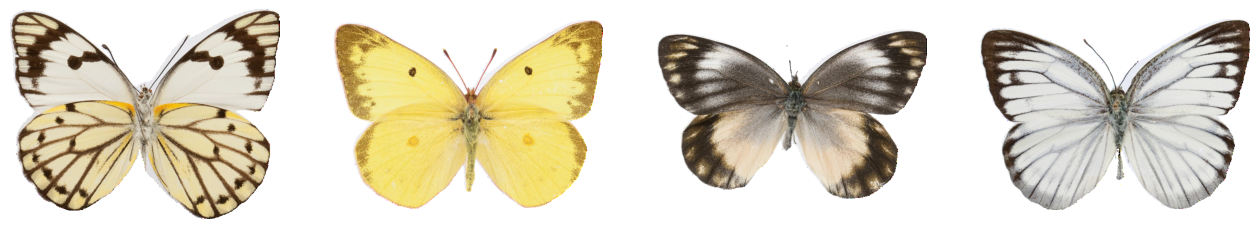

In [6]:
import matplotlib.pyplot as plt

fig, axs=plt.subplots(1,4,figsize=(16,4))
for i, image in enumerate(smaller_training[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

# Pre-processing data

The images are all diferent sizes though, so we'll need to preprocess them first:
* `Resize` changes the image size to the one defined in config.image_size
* `RandomHorizontalFlip` arguments the dataset by randomly mirroring the images
* `Normalize` is important to rescale the pixel values into a [-1,1] range, which is what the model expects

In [7]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=10), # Add ranfom rotation
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

Use Datasets' set transform method to apply the `preprocess` function on the fly during training:

In [8]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

smaller_training.set_transform(transform)

(Optional)Visualize the images again to confirm that they've been resized. Now you're ready to wrap the dataset in a DataLoader for training:

In [9]:
import torch


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic=True

train_dataloader = torch.utils.data.DataLoader(
    smaller_training,
    batch_size=config.train_batch_size,
    shuffle=True
)

len(train_dataloader)

25

# Creating an UNet2DModel

Preatained models in Diffusers are easily created from their model class with the parameters you want. For example, to create a $UNet2DModel$:

In [10]:
from diffusers import UNet2DModel

model=UNet2DModel(
    sample_size=config.image_size, # the target image resolution
    in_channels=3, # the number of input channels, 3 for RGB images
    out_channels=3, # the number of output channels
    layers_per_block=2, # how many ResNet layers to use per UNet block
    block_out_channels=(128,128,256,256,512,512), # the numbe of output channels for eaxh UNet block
    down_block_types=(
        "DownBlock2D", # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D", # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D", # a regular ResNet upsampling block
        "AttnUpBlock2D", # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
conv_in.weight 	 torch.Size([128, 3, 3, 3])
conv_in.bias 	 torch.Size([128])
time_embedding.linear_1.weight 	 torch.Size([512, 128])
time_embedding.linear_1.bias 	 torch.Size([512])
time_embedding.linear_2.weight 	 torch.Size([512, 512])
time_embedding.linear_2.bias 	 torch.Size([512])
down_blocks.0.resnets.0.norm1.weight 	 torch.Size([128])
down_blocks.0.resnets.0.norm1.bias 	 torch.Size([128])
down_blocks.0.resnets.0.conv1.weight 	 torch.Size([128, 128, 3, 3])
down_blocks.0.resnets.0.conv1.bias 	 torch.Size([128])
down_blocks.0.resnets.0.time_emb_proj.weight 	 torch.Size([128, 512])
down_blocks.0.resnets.0.time_emb_proj.bias 	 torch.Size([128])
down_blocks.0.resnets.0.norm2.weight 	 torch.Size([128])
down_blocks.0.resnets.0.norm2.bias 	 torch.Size([128])
down_blocks.0.resnets.0.conv2.weight 	 torch.Size([128, 128, 3, 3])
down_blocks.0.resnets.0.conv2.bias 	 torch.Size([128])
down_blocks.0.resnets.1.norm1.weight 	 torch.Size([128])
down_blocks.0.resnets.1.norm1.bia

Checking the sample image shape matches the model output shape:

In [11]:
sample_image = smaller_training[0]["images"].unsqueeze(0)
print("Input shape:", sample_image.shape)
print("Output shape:", model(sample_image, timestep=0).sample.shape)

Input shape: torch.Size([1, 3, 128, 128])
Output shape: torch.Size([1, 3, 128, 128])


# Adding some noise to the image

### Creating a scheduler

The scheduler behaves differently dependeing on whether you're using the model for training of inference.

* `During inference`, the scheduler generates image from the noise. 
* `During training`, the scheduler takes a model output or a sample from a specific point in the diffusion process and applies noise to the image according to a `noise schedule` and an `update rule`.

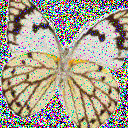

In [12]:
from PIL import Image
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1500)
noise=torch.randn(sample_image.shape)
timesteps=torch.LongTensor([50])
noisy_image=noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0,2,3,1)+1.0)*127.5).type(torch.uint8).numpy()[0])

The training objective of the model is to predict the noise added to the image. The loss at this step can be calculated by:

In [13]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
mse_loss = F.mse_loss(noise_pred, noise)
l1_loss = F.l1_loss(noise_pred, noise)
combined_loss = 0.7 * mse_loss +0.3*l1_loss # Combine MSE and L1 losses

# Train the model

### First, we will need an optimizer and a learning rate scheduler:

In [14]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=len(train_dataloader) * config.num_epochs,
)

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.0, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.01, 'amsgrad': False, 'foreach': None, 'maximize': False, 'capturable': False, 'differentiable': False, 'fused': None, 'initial_lr': 0.0001, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 

### Second, we will need a way to evaluate the model.

For evaluation, we can use the DDPMPipeline to generate a batch of sample images and save it as a grid:

In [15]:
from diffusers import DDPMPipeline
import math


def make_grid(images, rows, cols):
    w, h =images[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    return grid

def evaluate(config, epoch, pipeline):
    # Sample some image from random noise(this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images =pipeline(
        batch_size=config.eval_batch_size,
        generator = torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir=os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

### Wrapping all in a training loop

We can use Huggingface `Accelerate` for TensorBoard logging, gradient accumulation,and mixed precision training.

In [16]:
from __future__ import annotations
from accelerate import Accelerator
from huggingface_hub import HfFolder, Repository, whoami
from tqdm.auto import tqdm
from pathlib import Path


def get_full_repo_name(model_id:str, organization:str=None, token:str=None):
    if token is None:
        token=HfFolder.get_token()
    if organization is None:
        username = whoami(token=token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"


def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerato and tensorboard logging
    accelerator  = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.push_to_hub:
            repo_name=get_full_repo_name(Path(config.output_dir).name)
            repo=Repository(config.output_dir, clone_from=repo_name)
        elif config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")
    
    # Prepare all the components
    # There is no specific order to remember, you just need to unpack the objects in the same order you gave them to the prepare method
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model,
        optimizer,
        train_dataloader,
        lr_scheduler,
    )

    global_step = 0 #the global step across all epochs

    # Now we train the model
    for epoch in range(config.num_epochs):
        progress_bar =tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images=batch["images"]
            # Sample noise to add the images
            noise=torch.randn(clean_images.shape).to(clean_images.device)
            bs=clean_images.shape[0]

            # Sample a random temstep for each image
            timesteps=torch.randint(0, noise_scheduler.config.num_train_timesteps, size=(bs,), device=clean_images.device).long()

            # Add noise to the clean images according to the noise magnitude at each timestep (this is the forward diffusion process)
            noisy_images=noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss=F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)
                # https://github.com/huggingface/accelerate/issues/641
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            
            progress_bar.update(1)
            logs={"loss": loss.detach().item(),"lr": lr_scheduler.get_last_lr()[0],"step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs,step=global_step)
            global_step += 1

        
        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch+1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)
            
            if (epoch +1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    repo.push_to_hub(commit_message=f"Epoch {epoch}", blocking=True)
                else:
                    pipeline.save_pretrained(config.output_dir)

### Launch the training with Accelerate's notebook_launcher function

Pass the function to the training loop, all the training arguments and the number of processes(this value to the number of GPUs avaliable to you) to use for training:

In [17]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)
# TPU and Multiple-GPUs environment is so slow to start and always get stuck on "Launching training on two GPUs"
notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


2024-02-24 12:37:51.448924: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 12:37:51.449046: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 12:37:51.587779: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

# Checking the final images generated by the model

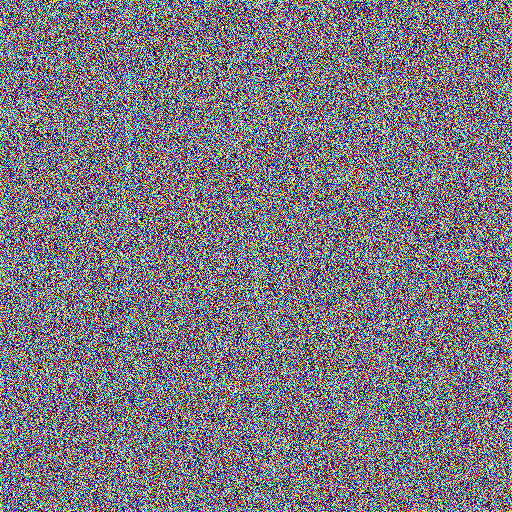

In [18]:
import glob

sample_images=sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])

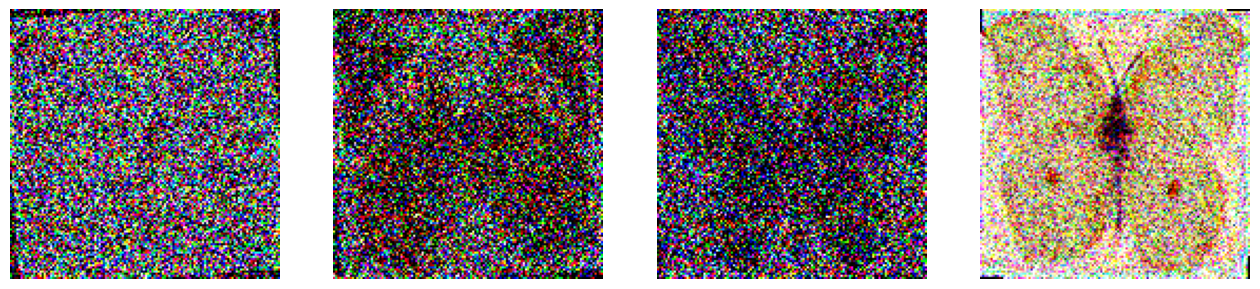

In [19]:
import matplotlib.pyplot as plt


try:
    # Evaluate the model on test data
    test_dataset = dataset['test'].select(range(100))
    test_dataset.set_transform(transform)
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=config.eval_batch_size,
        shuffle=False
    )

    # Evaluate the model on the test dataset and generate samples
    test_samples = []
    with torch.no_grad():
        for batch in test_dataloader:
            clean_images = batch["images"].to('cuda')
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, size=(clean_images.shape[0],), device=clean_images.device).long()

            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
            predicted_noise = model(noisy_images, timesteps, return_dict=False)[0]

            generated_images = torch.clamp(noisy_images - predicted_noise, -1.0, 1.0)
            test_samples.append(generated_images)    

    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    for i, generated_image in enumerate(test_samples[0][:4]):
        axs[i].imshow(generated_image.permute(1, 2, 0).cpu().numpy())
        axs[i].set_axis_off()
    fig.show()
except ValueError as ve:
    print(ve)